In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s.set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Assignment 2
## Problem 2
### (a) - (b)
Load the dataset and produce plots

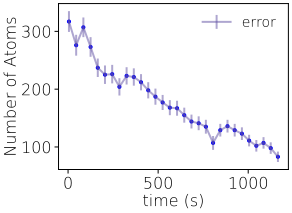

In [2]:
decay_data = np.loadtxt('data/decay.dat')
time    = decay_data[:,0]
N = decay_data[:,1]
ϵ = decay_data[:,2]

fig, ax = plt.subplots(figsize=(4,3))
ax.errorbar(time, N, ϵ, label='error',alpha=0.5)
ax.scatter(time, N, color='blue', s=10)
ax.set_xlabel("time (s)")
ax.set_ylabel("Number of Atoms")
ax.legend()

### (c) Data transformation
The analytical form for the data is:
\begin{equation}
    N(t) = N_\circ \; e^{-t/\tau}
\end{equation}
If we take log on both sides, 
\begin{equation}
    log(N(t)) = log(N_\circ) - \frac{t}{\tau}
\end{equation}

This is in the form $y = w_0 + w_1 t$, where $y = log(N(t)), w_0 = log(N_\circ) \text{ and } w_1 = -\frac{1}{\tau}$

### (d) Linear Regression

In [3]:
_N = np.log(N)

X = np.append(np.ones((time.shape[0],1)), time[:,np.newaxis], axis=1) # Append a column of 1-s
Y = np.reshape(_N, (_N.shape[0],1))
W = np.linalg.inv(X.T @ X) @ X.T @ Y

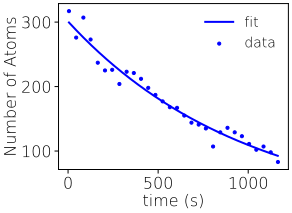

In [4]:
Nₒ = np.exp(W[0])
τ  = - 1.0 / W[1]

t_fit = np.arange(min(time), max(time))
N_fit = Nₒ * np.exp(-t_fit/τ)

fig, ax = plt.subplots(figsize=(4,3))
# ax.fill_between(time, N-ϵ, N+ϵ, alpha=0.3, edgecolor='blue', facecolor='blue', label='error')
ax.plot(t_fit, N_fit, color='blue', label='fit')
ax.scatter(time, N, color='blue', s=10, label='data')
ax.set_xlabel("time (s)")
ax.set_ylabel("Number of Atoms")
ax.legend()

### Problem 3
Non-Linear Curve Fitting via Gradient Descent
#### (a)-(b) load data and produce plots


Text(0, 0.5, 'Intensity')

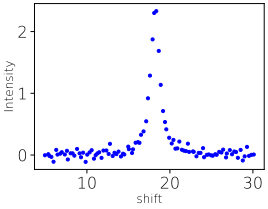

In [20]:
spectral_data = np.loadtxt('data/C60_nmr.dat')
δ             = spectral_data[:,0]
S             = spectral_data[:,1]

fig, ax = plt.subplots(figsize=(4,3))
ax.scatter(δ, S, color='blue', s=10)
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
ax.set_xlabel("shift", fontsize=12)
ax.set_ylabel("Intensity", fontsize=12)

### (c)-(d) least squares minimization
We need to fit this data to the model:
\begin{equation}
    S(\delta) = \frac{1}{(\delta-\alpha)^2 + \beta}
\end{equation}

Define the cost function as: 
\begin{equation}
    \mathcal{C} = \frac{1}{N}\sum_{i=0}^{N} \left[ S_i - \frac{1}{(\delta_i-\alpha)^2 + \beta} \right]^2
\end{equation}

It's derivatives can be analytically computed easily:
\begin{align}
    \frac{\partial \mathcal{C}}{\partial \alpha} &= - \frac{1}{N}\sum_{i=0}^{N} 4 \left[ S_i - \frac{1}{(\delta_i-\alpha)^2 + \beta} \right] \frac{\delta - \alpha}{((\delta_i-\alpha)^2 + \beta)^2} \\
    \frac{\partial \mathcal{C}}{\partial \beta} &= \frac{1}{N}\sum_{i=0}^{N} 4 \left[ S_i - \frac{1}{(\delta_i-\alpha)^2 + \beta} \right] \\
\end{align}

Least Square minimization code

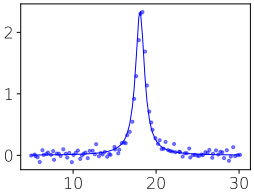

fit = 1/[(δ-18.058)^2 + 0.425]


In [164]:
from IPython.display import clear_output,display
from time import sleep

def cost(δ, S, α, β):
    return np.sum((S - 1/((δ - α)**2 + β))**2) / δ.shape[0]

def dC_dαβ(δ, S, α, β):
    '''
    return the derivative of the cost function with respect to the parameters
    uses analytice expressions for the derivatives since the cost is simple.

    '''
    dC_dα = np.sum(2 * (S - 1/((δ - α)**2 + β)) * (- 2*(δ - α)/((δ - α)**2 + β)**2)) / δ.shape[0]
    dC_dβ = np.sum(2 * (S - 1/((δ - α)**2 + β))) / δ.shape[0]

    return dC_dα, dC_dβ

num_iter = 0
Δ = 1
α = 15
β = 10
error = 1e4

while error>1.0e-2:
    dC_dα, dC_dβ = dC_dαβ(δ, S, α, β)
    α = α - Δ * dC_dα
    β = β - Δ * dC_dβ
    error = cost(δ, S, α, β)
    num_iter += 1
    
    clear_output(wait=True)
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3))
    ax.scatter(δ, S, color='blue', s=10, alpha=0.5, label='data')
    fit = 1/((δ - α)**2 + β)
    ax.plot(δ, fit, linewidth=1, color='b', label=f'fit')

    plt.show()
    sleep(0.01)

print(f'fit = 1/[(δ-{α:.3f})^2 + {β:.3f}]')

### (e) Using feature maps
We need make a feature map for the model:
\begin{equation}
    S(\delta) = \frac{1}{(\delta-\alpha)^2 + \beta}
\end{equation}

Transform it into a polynomial form by inverting both sides:
\begin{align}
    \frac{1}{S(\delta)} &= (\delta-\alpha)^2 + \beta \\
                        &= \delta^2 - 2 \alpha \; \delta + (\alpha^2 + \beta)
\end{align}

The quadratic term has no parameter associated with it, so we can jusr shift it to LHS:
\begin{align}
    \frac{1}{S(\delta)} - \delta^2 &= - 2 \alpha \; \delta + (\alpha^2 + \beta)
\end{align}

Now the equation is in the form $y = w_1 x + w_0$, where $\alpha = -0.5\,w_1,\; \beta = w_0 - \alpha^2$. we can create a simple feature map for this

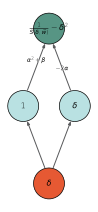

In [184]:
N = [1,2,1]
labels  = [[r'$\delta$'],['$1$','$\delta$'],[r'$\frac{1}{S(\delta,\vec{w})}-\delta^2$']]
weights = [['','',''],[r'$\alpha^2 + \beta$', r'$-2\alpha$', r'$1$']]
ml4s.draw_network(N,node_labels=labels, weights=weights, biases=[])

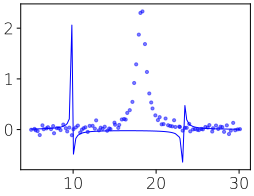

In [189]:
poly_order = 1
Φ = np.zeros([len(δ),poly_order+1])
for j in range(Φ.shape[1]):
    Φ[:,j] = δ**j

W_opt = np.dot(np.dot(np.linalg.inv(np.dot(Φ.T,Φ)),Φ.T),(1/S-δ**2))
α_fm = -0.5*W_opt[1]
β_fm = W_opt[0] - α_fm**2

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3))
ax.scatter(δ, S, color='blue', s=10, alpha=0.5, label='data')
fit2 = 1/((δ - α_fm)**2 + β_fm)
ax.plot(δ, fit2, linewidth=1, color='b', label=f'fit')

Did not seem to work because the values close to zero are blowing up on inverting.

In [165]:
# Write the parameters to a json file
import json
data = {
    "alpha": α,
    "beta": β,
    "num_iter": num_iter,
    "eta": Δ
    "alpha_fm": α_fm,
    "beta_fm": β_fm,
}
# Write to JSON
with open("data/C60_optimal.json", "w") as f:
    json.dump(data, f, indent=1)